In [1]:
import nni
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.evaluator.pytorch import DataLoader
from nni.nas.hub.pytorch import DARTS as DartsSpace

CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])
valid_data = nni.trace(CIFAR10)(root='./data', train=False, download=True, transform=transform_valid)
valid_loader = DataLoader(valid_data, batch_size=256, num_workers=6)

/home/kharratw/Documents/PFE/.venv/lib/python3.12/site-packages/nni/nas/nn/pytorch/layers.py:94: RuntimeWarning: <class 'torch.nn.parameter.Buffer'> is found to be not a nn.Module, which is unexpected. It means your PyTorch version might not be supported.
  warnings.warn(f'{obj} is found to be not a nn.Module, which is unexpected. '


In [2]:
%pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


Defining the darts search space and strategy ( Determine the cells structure )

In [3]:
model_space = DartsSpace(
    width=16,           # the initial filters (channel number) for the model
    num_cells=8,        # the number of stacked cells in total
    dataset='cifar'     # to give a hint about input resolution, here is 32x32
)

In [4]:
fast_dev_run = False

In [5]:
import numpy as np
from nni.nas.evaluator.pytorch import Classification
from torch.utils.data import SubsetRandomSampler

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

train_data = nni.trace(CIFAR10)(root='./data', train=True, download=True, transform=transform)

num_samples = len(train_data)
indices = np.random.permutation(num_samples)
split = num_samples // 2

search_train_loader = DataLoader(
    train_data, batch_size=64, num_workers=6,
    sampler=SubsetRandomSampler(indices[:split]),
)

search_valid_loader = DataLoader(
    train_data, batch_size=64, num_workers=6,
    sampler=SubsetRandomSampler(indices[split:]),
)

evaluator = Classification(
    learning_rate=1e-3,
    weight_decay=1e-4,
    train_dataloaders=search_train_loader,
    val_dataloaders=search_valid_loader,
    max_epochs=10,
    fast_dev_run=True,
    num_classes=10
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [6]:
from nni.nas.strategy import DARTS as DartsStrategy

strategy = DartsStrategy()

In [7]:
from nni.nas.experiment import NasExperiment

experiment = NasExperiment(model_space, evaluator, strategy)
experiment.run()

[2025-04-23 14:14:44] Config is not provided. Will try to infer.
[2025-04-23 14:14:44] Strategy is found to be a one-shot strategy. Setting execution engine to "sequential" and format to "raw".
[2025-04-23 14:14:44] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:44] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:44] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:46] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:46] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:46] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:46] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:46] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | training_module | ClassificationModule | 2.0 M  | train
-----------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.950     Total estimated model params size (MB)
8031      Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.32it/s, train_loss=2.350, train_acc=0.156]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  0.31it/s, train_loss=2.350, train_acc=0.156]
[2025-04-23 14:14:51] Waiting for models submitted to engine to finish...
[2025-04-23 14:14:51] Experiment is completed.
[2025-04-23 14:14:51] WARNING: `training_service` will be ignored for sequential execution engine.


True

In [8]:
exported_arch = experiment.export_top_models(formatter='dict')[0]

exported_arch

[2025-04-23 14:14:51] Sorted weights in differentiable cell export (normal cell, node 2): [(0.0020544365979731083, 1, 'skip_connect'), (0.0007125369156710804, 0, 'dil_conv_3x3'), (0.0011667790822684765, 1, 'dil_conv_3x3'), (0.0009830546332523227, 1, 'avg_pool_3x3'), (0.00023309637617785484, 0, 'dil_conv_5x5'), (-2.7433121431386098e-05, 1, 'sep_conv_5x5'), (-9.45566498558037e-05, 0, 'avg_pool_3x3'), (-0.00021196043235249817, 0, 'sep_conv_3x3'), (-0.00034153895103372633, 1, 'dil_conv_5x5'), (-0.0004041800566483289, 0, 'sep_conv_5x5'), (-0.0008792590815573931, 1, 'sep_conv_3x3'), (-0.0009262190433219075, 0, 'skip_connect'), (-0.0012761004036292434, 1, 'max_pool_3x3'), (-0.0020128493197262287, 0, 'max_pool_3x3')]
[2025-04-23 14:14:51] Sorted weights in differentiable cell export (normal cell, node 3): [(0.001418561558239162, 2, 'skip_connect'), (0.0012586255325004458, 1, 'sep_conv_5x5'), (0.0007076565525494516, 0, 'avg_pool_3x3'), (0.0012402452994138002, 2, 'max_pool_3x3'), (0.000677732925

{'normal/op_2_0': 'skip_connect',
 'normal/input_2_0': [1],
 'normal/op_2_1': 'dil_conv_3x3',
 'normal/input_2_1': [0],
 'normal/op_3_0': 'skip_connect',
 'normal/input_3_0': [2],
 'normal/op_3_1': 'sep_conv_5x5',
 'normal/input_3_1': [1],
 'normal/op_4_0': 'max_pool_3x3',
 'normal/input_4_0': [1],
 'normal/op_4_1': 'dil_conv_5x5',
 'normal/input_4_1': [0],
 'normal/op_5_0': 'sep_conv_3x3',
 'normal/input_5_0': [1],
 'normal/op_5_1': 'dil_conv_5x5',
 'normal/input_5_1': [0],
 'reduce/op_2_0': 'avg_pool_3x3',
 'reduce/input_2_0': [1],
 'reduce/op_2_1': 'skip_connect',
 'reduce/input_2_1': [0],
 'reduce/op_3_0': 'max_pool_3x3',
 'reduce/input_3_0': [0],
 'reduce/op_3_1': 'avg_pool_3x3',
 'reduce/input_3_1': [1],
 'reduce/op_4_0': 'avg_pool_3x3',
 'reduce/input_4_0': [3],
 'reduce/op_4_1': 'sep_conv_3x3',
 'reduce/input_4_1': [2],
 'reduce/op_5_0': 'dil_conv_5x5',
 'reduce/input_5_0': [0],
 'reduce/op_5_1': 'max_pool_3x3',
 'reduce/input_5_1': [2]}

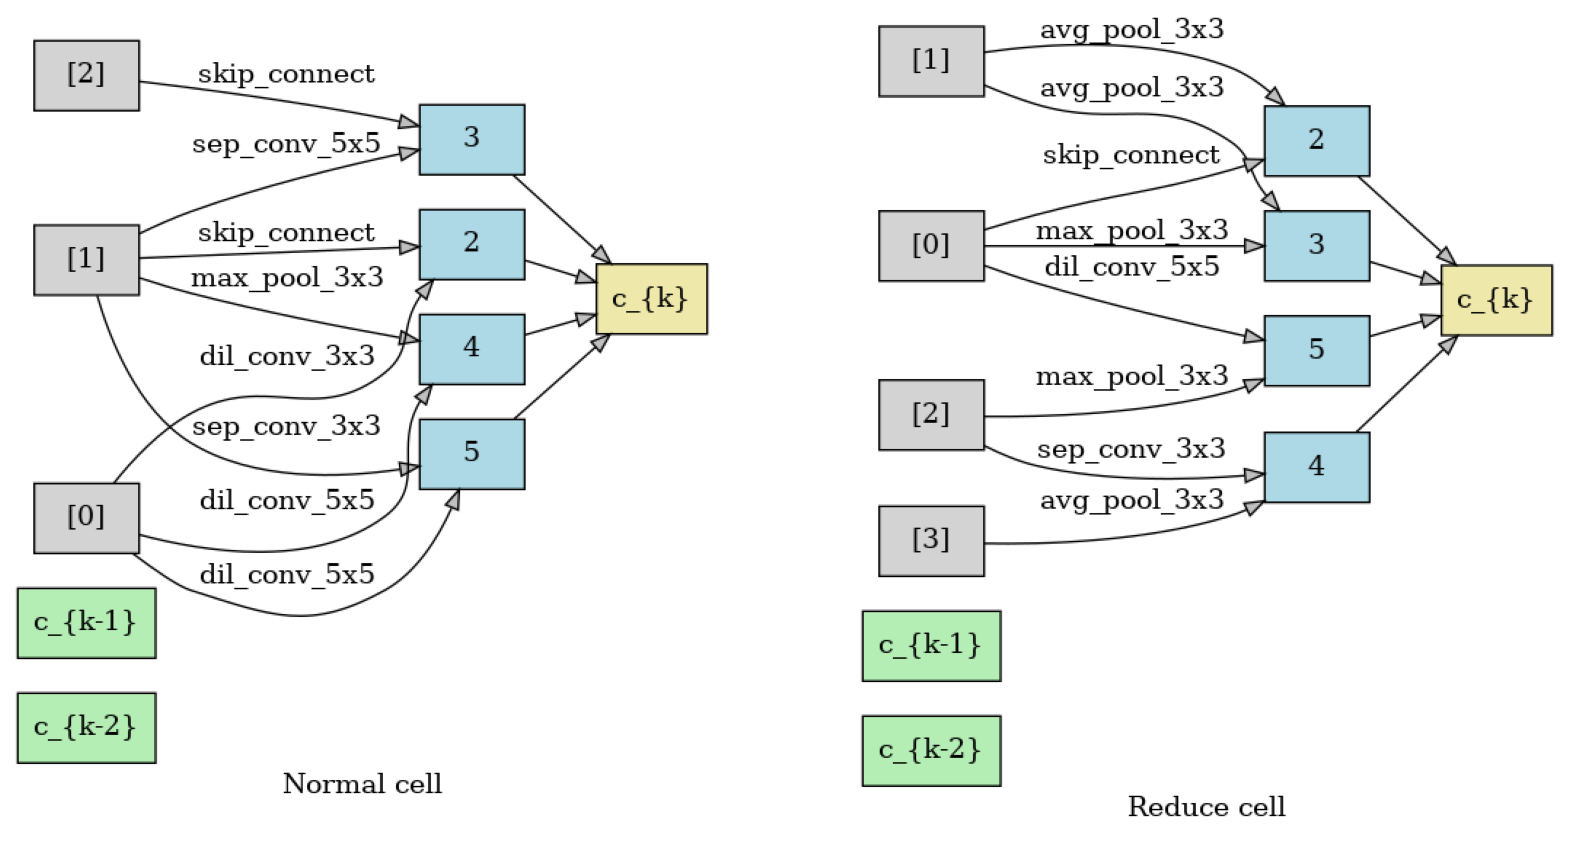

In [9]:
import io
import graphviz
import matplotlib.pyplot as plt
from PIL import Image

def plot_single_cell(arch_dict, cell_name):
    g = graphviz.Digraph(
        node_attr=dict(style='filled', shape='rect', align='center'),
        format='png'
    )
    g.body.extend(['rankdir=LR'])

    g.node('c_{k-2}', fillcolor='darkseagreen2')
    g.node('c_{k-1}', fillcolor='darkseagreen2')
    assert len(arch_dict) % 2 == 0

    for i in range(2, 6):
        g.node(str(i), fillcolor='lightblue')

    for i in range(2, 6):
        for j in range(2):
            op = arch_dict[f'{cell_name}/op_{i}_{j}']
            from_ = arch_dict[f'{cell_name}/input_{i}_{j}']
            if from_ == 0:
                u = 'c_{k-2}'
            elif from_ == 1:
                u = 'c_{k-1}'
            else:
                u = str(from_)
            v = str(i)
            g.edge(u, v, label=op, fillcolor='gray')

    g.node('c_{k}', fillcolor='palegoldenrod')
    for i in range(2, 6):
        g.edge(str(i), 'c_{k}', fillcolor='gray')

    g.attr(label=f'{cell_name.capitalize()} cell')

    image = Image.open(io.BytesIO(g.pipe()))
    return image

def plot_double_cells(arch_dict):
    image1 = plot_single_cell(arch_dict, 'normal')
    image2 = plot_single_cell(arch_dict, 'reduce')
    height_ratio = max(image1.size[1] / image1.size[0], image2.size[1] / image2.size[0])
    _, axs = plt.subplots(1, 2, figsize=(20, 10 * height_ratio))
    axs[0].imshow(image1)
    axs[1].imshow(image2)
    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

plot_double_cells(exported_arch)

Retrain the searched model

In [10]:
from nni.nas.space import model_context

with model_context(exported_arch):
    final_model = DartsSpace(width=16, num_cells=8, dataset='cifar')

In [11]:
train_loader = DataLoader(train_data, batch_size=96, num_workers=6)  # Use the original training data

In [12]:
valid_loader

In [13]:
max_epochs = 100

evaluator = Classification(
    learning_rate=1e-3,
    weight_decay=1e-4,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
    max_epochs=max_epochs,
    num_classes=10,
    export_onnx=False,          # Disable ONNX export for this experiment
    fast_dev_run=True   # Should be false for fully training
)

evaluator.fit(final_model)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | metrics   | ModuleDict       | 0      | train
2 | _model    | DARTS            | 232 K  | train
-------------------------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.932     Total estimated model params size (MB)
515       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, train_loss=2.340, train_acc=0.104, val_loss=2.300, val_acc=0.0898]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s, train_loss=2.340, train_acc=0.104, val_loss=2.300, val_acc=0.0898]
[2025-04-23 14:14:54] Final result: 0.08984375


Reproduce results in DARTS paper

In [14]:
import torch
from nni.nas.evaluator.pytorch import ClassificationModule

class DartsClassificationModule(ClassificationModule):
    def __init__(
        self,
        learning_rate: float = 0.001,
        weight_decay: float = 0.,
        auxiliary_loss_weight: float = 0.4,
        max_epochs: int = 300,
        num_classes: int = 10,
    ):
        self.auxiliary_loss_weight = auxiliary_loss_weight
        # Training length will be used in LR scheduler
        self.max_epochs = max_epochs
        super().__init__(learning_rate=learning_rate, weight_decay=weight_decay, num_classes=num_classes, export_onnx=False)

    def configure_optimizers(self):
        """Customized optimizer with momentum, as well as a scheduler."""
        optimizer = torch.optim.SGD(
            self.parameters(),
            momentum=0.9,
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.max_epochs, eta_min=1e-3)
        }

    def training_step(self, batch, batch_idx):
        """Training step, customized with auxiliary loss."""
        x, y = batch
        if self.auxiliary_loss_weight:
            y_hat, y_aux = self(x)
            loss_main = self.criterion(y_hat, y)
            loss_aux = self.criterion(y_aux, y)
            self.log('train_loss_main', loss_main)
            self.log('train_loss_aux', loss_aux)
            loss = loss_main + self.auxiliary_loss_weight * loss_aux
        else:
            y_hat = self(x)
            loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        for name, metric in self.metrics.items():
            self.log('train_' + name, metric(y_hat, y), prog_bar=True)
        return loss

    def on_train_epoch_start(self):
        # Set drop path probability before every epoch. This has no effect if drop path is not enabled in model.
        self.model.set_drop_path_prob(self.model.drop_path_prob * self.current_epoch / self.max_epochs)

        # Logging learning rate at the beginning of every epoch
        self.log('lr', self.trainer.optimizers[0].param_groups[0]['lr'])

In [ ]:
from nni.nas.evaluator.pytorch import Lightning, Trainer

max_epochs = 50

evaluator = Lightning(
    DartsClassificationModule(0.025, 3e-4, 0., 10),
    Trainer(
        max_epochs=max_epochs,
        fast_dev_run=False,
    ),
    train_dataloaders=search_train_loader,
    val_dataloaders=search_valid_loader
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
strategy = DartsStrategy(gradient_clip_val=5.)

In [17]:
model_space = DartsSpace(width=16, num_cells=8, dataset='cifar')

experiment = NasExperiment(model_space, evaluator, strategy)
experiment.run()

exported_arch = experiment.export_top_models(formatter='dict')[0]

exported_arch

[2025-04-23 14:14:54] Config is not provided. Will try to infer.
[2025-04-23 14:14:54] Strategy is found to be a one-shot strategy. Setting execution engine to "sequential" and format to "raw".
[2025-04-23 14:14:54] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:54] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:54] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:56] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:56] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:56] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:56] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14:14:56] WARNING: `training_service` will be ignored for sequential execution engine.
[2025-04-23 14

2025-04-23 14:14:57.246826: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 14:14:57.267696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745410497.285762  124184 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745410497.291153  124184 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745410497.304876  124184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 13:  28%|██▊       | 109/391 [02:37<06:47,  0.69it/s, v_num=1, train_loss=0.593, train_acc=0.812]


Detected KeyboardInterrupt, attempting graceful shutdown ...


[2025-04-23 16:27:09] ERROR: Model 1 fails to be executed.
[2025-04-23 16:27:09] ERROR: Strategy failed to execute.


NameError: name 'exit' is not defined

In [ ]:
import io
import graphviz
import matplotlib.pyplot as plt
from PIL import Image

def plot_single_cell(arch_dict, cell_name):
    g = graphviz.Digraph(
        node_attr=dict(style='filled', shape='rect', align='center'),
        format='png'
    )
    g.body.extend(['rankdir=LR'])

    g.node('c_{k-2}', fillcolor='darkseagreen2')
    g.node('c_{k-1}', fillcolor='darkseagreen2')
    assert len(arch_dict) % 2 == 0

    for i in range(2, 6):
        g.node(str(i), fillcolor='lightblue')

    for i in range(2, 6):
        for j in range(2):
            op = arch_dict[f'{cell_name}/op_{i}_{j}']
            from_ = arch_dict[f'{cell_name}/input_{i}_{j}']
            if from_ == 0:
                u = 'c_{k-2}'
            elif from_ == 1:
                u = 'c_{k-1}'
            else:
                u = str(from_)
            v = str(i)
            g.edge(u, v, label=op, fillcolor='gray')

    g.node('c_{k}', fillcolor='palegoldenrod')
    for i in range(2, 6):
        g.edge(str(i), 'c_{k}', fillcolor='gray')

    g.attr(label=f'{cell_name.capitalize()} cell')

    image = Image.open(io.BytesIO(g.pipe()))
    return image

def plot_double_cells(arch_dict):
    image1 = plot_single_cell(arch_dict, 'normal')
    image2 = plot_single_cell(arch_dict, 'reduce')
    height_ratio = max(image1.size[1] / image1.size[0], image2.size[1] / image2.size[0])
    _, axs = plt.subplots(1, 2, figsize=(20, 10 * height_ratio))
    axs[0].imshow(image1)
    axs[1].imshow(image2)
    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

plot_double_cells(exported_arch)

In [ ]:
def cutout_transform(img, length: int = 16):
    h, w = img.size(1), img.size(2)
    mask = np.ones((h, w), np.float32)
    y = np.random.randint(h)
    x = np.random.randint(w)

    y1 = np.clip(y - length // 2, 0, h)
    y2 = np.clip(y + length // 2, 0, h)
    x1 = np.clip(x - length // 2, 0, w)
    x2 = np.clip(x + length // 2, 0, w)

    mask[y1: y2, x1: x2] = 0.
    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    img *= mask
    return img

transform_with_cutout = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    cutout_transform,
])

In [ ]:
train_data_cutout = nni.trace(CIFAR10)(root='./data', train=True, download=True, transform=transform_with_cutout)
train_loader_cutout = DataLoader(train_data_cutout, batch_size=96)

In [ ]:
with model_context(exported_arch):
    final_model = DartsSpace(width=36, num_cells=20, dataset='cifar', auxiliary_loss=True, drop_path_prob=0.2)

In [ ]:
max_epochs = 30

evaluator = Lightning(
    DartsClassificationModule(0.025, 3e-4, 0.4, 10),
    trainer=Trainer(
        gradient_clip_val=5.,
        max_epochs=max_epochs,
        fast_dev_run=fast_dev_run
    ),
    train_dataloaders=train_loader_cutout,
    val_dataloaders=valid_loader,
)

evaluator.fit(final_model)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | metrics   | ModuleDict       | 0      | train
2 | _model    | DARTS            | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.972    Total estimated model params size (MB)
1520      Modules in train mode
0         Modules in eval mode


Epoch 29: 100%|██████████| 521/521 [02:18<00:00,  3.77it/s, v_num=9, train_loss=1.220, train_acc=0.675, val_loss=0.326, val_acc=0.894]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 521/521 [02:18<00:00,  3.76it/s, v_num=9, train_loss=1.220, train_acc=0.675, val_loss=0.326, val_acc=0.894]
[2025-04-18 15:25:37] Final result: 0.8938999772071838
